In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Gaussian Process
### The Gaussian Process is for 1D input data to visualize the data and prediction.

In [2]:
class GaussianProcess:
    
    """
    __init__(self, sig_f, l, sig_y) : Initialize the model with the given parameters
    
    kernel(self, x1, x2) : Select a kernel method (In this code, the squared exponential kernel is used.)
    
    fit(self, x, y) : Fit the model to the training data
    
    predict(self, x): Compute the prediction (mu_* tilda and Sigma_* tilda)
    
    evaluate(self, y,y_hat): Compute L2 loss between actual y values and prediction y_hat values
    
    optimize(self, maxiter=20000, tol=1e-4) : Find the optimal parameters sig_f, sig_y, and l
    
    """
    def __init__(self, sig_f, l, sig_y):
        self.sig_f = sig_f
        self.l = l
        self.sig_y = sig_y
        
    def kernel(self, x1, x2):
        n = len(x1)
        m = len(x2)
        ker = np.zeros((n,m))
        norm = np.zeros((n,m))
        for i in range(n):
            for j in range(m):
                norm[i][j] = (x1[i]-x2[j])**2
                ker[i][j] = (self.sig_f**2)*np.exp(-0.5*norm[i][j]/(self.l**2))
        ker = np.round(ker,4)  
        self.norm = norm
        return ker   
        
    def fit(self, x, y):
        self.x_train = x 
        self.y_train = y
        self.len = len(self.x_train)
        # K_y = K + sig_y**2*I, alpha = inv(K_y)Y
        self.K = self.kernel(self.x_train, self.x_train)
        self.K_y = self.K + (self.sig_y**2)*np.identity(self.len)
        self.alpha = np.matmul(np.linalg.inv(self.K_y),y)
        return self
    
    def predict(self, x):
        k_s = self.kernel(self.x_train, x)
        mu_s =  np.matmul(k_s.T,self.alpha).reshape(-1)
        k_tilda = (self.kernel(x, x) + (self.sig_y**2)*np.identity(len(x))
                - np.matmul(np.matmul(k_s.T,np.linalg.inv(self.K_y)),k_s))
        
        return mu_s, k_tilda
        
    def evaluate(self, y,y_hat):
        # L2 loss
        loss = np.sum((y-y_hat)**2)
        return loss
    
    def optimize(self, maxiter=20000, tol=1e-4):
    
        n = self.len
      
        grad_norm = 10
        count = 0
        self.fit(self.x_train,self.y_train)
        lr = 5e-3
        while grad_norm > tol:
            
            dK_y_f = self.K/(self.sig_f**2)     
            dK_y_l = self.K/(self.l**3)*self.norm
            
            # Gradient 
            # dL/d(sig_f**2)
            g_a = (.5*(np.matmul(np.matmul(self.alpha.T,dK_y_f),self.alpha)
                      -np.trace(np.matmul(np.linalg.inv(self.K_y),dK_y_f))))
            # dL/dl
            g_b = (.5*(np.matmul(np.matmul(self.alpha.T,dK_y_l),self.alpha) 
                      -np.trace(np.matmul(np.linalg.inv(self.K_y),dK_y_l))))
            # dL/d(sig_y**2)
            g_c = .5*(np.dot(self.alpha,self.alpha)-np.trace(np.linalg.inv(self.K_y)))
            
            # Comparison between grad_norm and tolerance
            grad_norm = np.sqrt(g_a**2 + g_b**2 + g_c**2)
            
            # Gradient Descent     
            self.sig_f = np.sqrt(self.sig_f**2 +lr*g_a)                   
            self.l = self.l +lr*g_b
            self.sig_y = np.sqrt(self.sig_y**2 +lr*g_c)
            #print(self.sig_f, self.l, self.sig_y)
            
            self.fit(self.x_train,self.y_train)
            
            if count % 2000 == 0:
                print(count, grad_norm)
            count += 1
            if count > maxiter:
                break
        print(count, grad_norm)    
        return self.sig_f, self.l, self.sig_y
        

### Step1: Load training data

In [3]:
x = np.array([-3,-2.3,-1.3,-0.3,0,0.1,0.5,1.2,2,3])
np.random.seed(0)
y = 2*np.sin(2*x)*np.exp(-0.5*x) + np.random.normal(0, 0.5, 10)

### Step2: Fit the model to the training data with sig_f=1, sig_y=0.5, and l=1

In [4]:
gp = GaussianProcess(1,0.5,1)
gp.fit(x,y)

### Step3: Predict the test data

In [5]:
y_pred, s = gp.predict(x)

### Step4: Compute Loss

In [6]:
ini_loss = gp.evaluate(y,y_pred)
print(f'Loss: {ini_loss}')

Loss: 13.454029833232129


### Step5: Plot the prediction and actual values with its margin

In [7]:
x_domain = np.linspace(np.min(x)-0.5, np.max(x)+0.5, 100)
y_pred, s = gp.predict(x_domain)

# Ground True
y_true = 2*np.sin(2*x_domain)*np.exp(-0.5*x_domain)

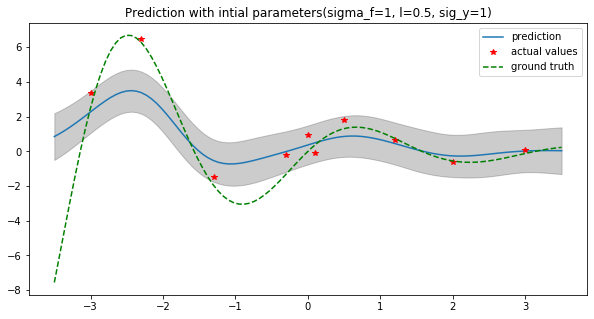

In [8]:
fig = plt.figure(figsize=(10,5))
plt.plot(x_domain, y_pred)
plt.plot(x,y,'r*')
plt.plot(x_domain,y_true,'g--')
plt.fill_between(x_domain, y_pred - np.sqrt(np.diag(s)), y_pred + np.sqrt(np.diag(s)),color="k", alpha=0.2)
plt.title("Prediction with intial parameters(sigma_f=1, l=0.5, sig_y=1)")
#plt.ylim(-8,10)
plt.legend(['prediction','actual values','ground truth'])
plt.show()

### Step6: Find the optimal parameters sig_f, sig_y, and l by a gradient descent method

In [9]:
sig_f, l, sig_y = gp.optimize()
print(f'Optimal parameters: sig_f={sig_f}, l={l}, sig_y={sig_y}')

0 7.0032138852453185
2000 0.15169807123756002
4000 0.04473436315910472
6000 0.018234750050815058
8000 0.00824541738877109
10000 0.003830774781661794
12000 0.0019008153608576735
14000 0.0009183398301756277
16000 0.00043186983739888074
18000 0.0004311070128152686
20000 0.00027656125063299405
20001 0.00027656125063299405
Optimal parameters: sig_f=2.485972990449694, l=0.6229510873830252, sig_y=0.7649201744825703


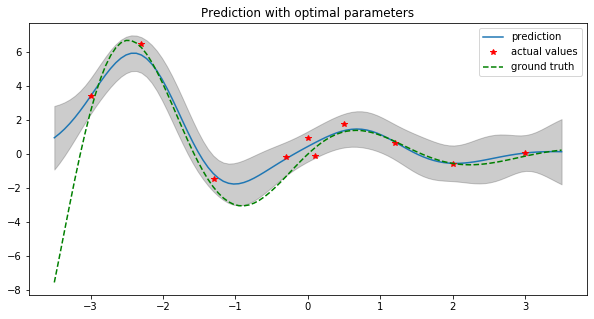

In [10]:
# Prediction with optimal parameters
gp = GaussianProcess(sig_f, l, sig_y)
gp.fit(x,y)
y_pred, s = gp.predict(x_domain)
fig = plt.figure(figsize=(10,5))
plt.plot(x_domain, y_pred)
plt.plot(x,y,'r*')
plt.fill_between(x_domain, y_pred - np.sqrt(np.diag(s)), y_pred + np.sqrt(np.diag(s)),color="k", alpha=0.2)
plt.plot(x_domain,y_true,'g--')
plt.legend(['prediction','actual values','ground truth'])
plt.title("Prediction with optimal parameters")
plt.show()

### Step7: Compare the loss between initial and optimal parameters 

In [11]:
y_pred, s = gp.predict(x)
print(f'Loss with initial parameters: {ini_loss}')
print(f'Loss with optimal parameters: {gp.evaluate(y,y_pred)}')

Loss with initial parameters: 13.454029833232129
Loss with optimal parameters: 1.539562980847597
